In [1]:
import numpy as np
import matplotlib.pyplot as plt
import client_moodle as server
import random
%matplotlib inline

In [2]:
# constants
TEAM_ID = 'dGtgGZhUiTAytVHtKMwFEbEBZl9vcBwrsP5rOSTTrLQuOsDAY2'

GENE_MIN = -10
GENE_MAX = 10

CHROMOSOME_SIZE = 11
POPULATION_SIZE = 8 # Keep power of 2

# GAUSS_NOISE_MEAN = 0.0
# GAUSS_NOISE_STD = 1

MUTATE_PROB = 0.3
MAX_MUTATE_DEC = 100 # just change the power

NUM_GENERATIONS = 10

In [3]:
INITIAL_WEIGHTS = [ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.94890102e-11, -4.86466915e-12]
len(INITIAL_WEIGHTS)

11

In [4]:
def generate_random_from_seed(val: list) -> np.ndarray:
        '''
        Generates a population from a single seed chromosome
        '''
        
        temp = [list(val) for i in range(POPULATION_SIZE)]
        temp = np.array(temp, dtype=np.double)
        
        for idx, val in np.ndenumerate(temp):
            noise = np.random.normal(loc=temp[idx], scale=abs(temp[idx])/10000000000000000)
            temp[idx] += noise

        np.clip(noise + temp, GENE_MIN, GENE_MAX)

generate_random_from_seed(INITIAL_WEIGHTS)

In [5]:
class Darwin:
    '''
    This class encapsulates a genetic algorithm runner over population consisting of weight vectors
    '''
    CHROMOSOME_SIZE = CHROMOSOME_SIZE
    POPULATION_SIZE = POPULATION_SIZE

    def __init__(self, val: list):
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError

        self.population = self.generate_random_from_seed(val)
        self.population[0] = np.array(val)
        self.avg_fitness = [] # maintained across generations
        self.weight_fitness_map = [] # consists of tuples (vector,fitness)
        self.max_fitness_across_generations = None
        self.best_chromosome_across_generations = None
        self.train_for_best_chromosome = None
        self.valid_for_best_chromosome = None
        self.store = []

    def generate_random_from_seed(self, val: list) -> np.ndarray:
        '''
        Generates a population from a single seed chromosome
        '''
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError
#         ---new function---
        temp = [list(val) for i in range(self.POPULATION_SIZE)]
        temp = np.array(temp, dtype=np.double)
        temp =  self.mutate(temp)
        temp[0] = val
        return temp
#         ---old function---
#         temp = [list(val) for i in range(self.POPULATION_SIZE)]
#         temp = np.array(temp, dtype=np.double)
        
#         for idx, val in np.ndenumerate(temp):
#             noise = np.random.normal(loc=temp[idx], scale=abs(temp[idx]))
#             temp[idx] += noise

#         return np.clip(noise + temp, GENE_MIN, GENE_MAX)

    def get_fitness(self):
        
        def error_to_fitness(train_err, valid_err):
            return -(train_err + valid_err)
        

        fitness = []
        train_errors = []
        valid_errors = []
        weight_fitness = []
        for chrom in self.population:
            train_err, valid_err = server.get_errors(TEAM_ID, list(chrom))
            fit = error_to_fitness(train_err, valid_err)
            fitness.append(fit)
            self.store.append((chrom,fit,train_err,valid_err))
            train_errors.append(train_err)
            valid_errors.append(valid_err)
            weight_fitness.append((chrom,fit))

        fitness = np.array(fitness, dtype=np.double)
        self.weight_fitness_map = weight_fitness
        return fitness, train_errors, valid_errors

    @classmethod
    def crossover(self, mom: np.ndarray, dad: np.ndarray):
        '''
        Generates offsprings out of the two parents
        '''

        def random_prefix(mom: np.ndarray, dad: np.ndarray):
            '''
            Random prefixes and suffixes
            '''
            thresh = np.random.randint(self.CHROMOSOME_SIZE) # index
            print("doing crossover between :-")
            print(mom)
            print(dad)
            alice = np.copy(dad)
            bob = np.copy(mom)
            print("And the random point of cutting was "+str(thresh))
            alice[0:thresh] = mom[0:thresh]
            bob[0:thresh] = dad[0:thresh]
            print("new children are :-")
            print(alice)
            print(bob)
            return alice,bob

        return random_prefix(mom, dad)

    @classmethod
    def mutate(self, population: np.ndarray):
        '''
        Mutates the population randomly
        '''
        
        def add_gauss_noise(population: np.ndarray):
            '''
            Adds a gaussian noise to some of the elements
            '''
            means = np.mean(population, axis=0) # mean of each gene across the population - to keep mutations of level
            
            # TODO: vectorise
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    noise = np.random.normal(loc=means[idx[1]], scale=abs(means[idx[1]]/1000000000000000))
                    population[idx] += noise

            return np.clip(population, GENE_MIN, GENE_MAX)
        
        def add_uniform_noise(population: np.ndarray):
            
            means = np.mean(population, axis=0)
            delta = means/20
            
            for weights in population:
                guess = random.randint(0,2)
                noise = np.random.uniform(means - delta, means + delta)
                if guess == 1:
                    weights = weights + noise
                else:
                    weights = weights - noise
            return population
        
        def add_noise(population: np.ndarray):
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    range_lim = val/MAX_MUTATE_DEC
                    noise = np.random.uniform(low=-range_lim, high=range_lim)
                    population[idx] = population[idx] + noise
            return np.clip(population, GENE_MIN, GENE_MAX)
            
        temp = add_noise(population)
        print("Changes due to mutation")
        for i in range(POPULATION_SIZE):
            for j in range(CHROMOSOME_SIZE):
                print(population[i][j],end="")
                print("->",end="")
                print(temp[i][j])
            print("-----------------------------")
            
        return temp

    def breed(self):
        '''
        Creates the next generation
        '''

        def russian_roulette():
            '''
            Whenever a parent is required, one is selected with probability proportional to fitness
            '''

            def get_parent_index(thresholds):
                draw = np.random.random() # in [0, 1)

                for i in range(len(thresholds)):
                    if draw < thresholds[i]:
                        return i
                return len(thresholds) - 1    
            
            fitness, train_errors, valid_errors = self.get_fitness()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness, train_errors, valid_errors)

            thresholds = []
            thresh = 0.0
            fitness_sum = np.sum(normalized_fitness)
            for val in normalized_fitness:
                thresh = thresh + (val/fitness_sum)
                thresholds.append(thresh)

            offsprings = []
            for i in range(int(self.POPULATION_SIZE/2)):
                mom = self.population[get_parent_index(thresholds)]
                dad = self.population[get_parent_index(thresholds)]

                alice, bob = self.crossover(mom, dad)
                offsprings.append(alice)
                offsprings.append(bob)
                
            return np.array(offsprings, dtype=np.double)
        
        def Sort_Tuple(tup):
            tup.sort(key = lambda x: x[1])  
            return tup  
        
        
        def normal_breed():
            # use the 1 best parent from previous population and breed using 6 vectors to get 6C2 = 15 new children
            fitness,train,valid = self.get_fitness()
            self.weight_fitness_map = Sort_Tuple(self.weight_fitness_map)
            self.weight_fitness_map.reverse()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness,train,valid)
            
            offsprings = []
            for i in range(4):
                for j in range(i+1,4):
                    mom = self.weight_fitness_map[i][0]
                    dad = self.weight_fitness_map[j][0]
                    
                    alice, bob = self.crossover(mom,dad)
                    offsprings.append(alice)
#                     offsprings.append(bob)
            
            offsprings.append(self.weight_fitness_map[0][0]) # this adds the best from the previous population
            offsprings.append(self.weight_fitness_map[1][0])
            
            return np.array(offsprings, dtype=np.double)
        
        offsprings = russian_roulette()
        self.population = self.mutate(offsprings)
    
    def update_best(self, fitness: np.ndarray, train_errors: list, valid_errors: list):
        '''
        Updates the best chromosome across generations parameter from self.population
        '''
        best_idx = np.argmax(fitness)
        if (not self.max_fitness_across_generations) or fitness[best_idx] > self.max_fitness_across_generations:
            self.max_fitness_across_generations = fitness[best_idx]
            self.best_chromosome_across_generations = self.population[best_idx]
            self.train_for_best_chromosome = train_errors[best_idx]
            self.valid_for_best_chromosome = valid_errors[best_idx]

    def train(self):

        for i in range(NUM_GENERATIONS):
            self.breed()
        
        plt.plot(self.avg_fitness)
        plt.xlabel('Generations', fontsize=12)
        plt.ylabel('Average Fitness', fontsize=12)
        plt.title('Average Fitness across Generations', fontsize=14)
        plt.show()

        # haven't calculated the fitness of the final population
#         fitness, train_err, valid_err = self.get_fitness()
#         self.update_best(fitness, train_err, valid_err)
        
        return self.best_chromosome_across_generations, self.max_fitness_across_generations, self.train_for_best_chromosome, self.valid_for_best_chromosome


In [6]:
darwin = Darwin(INITIAL_WEIGHTS)
darwin.population[0]

Changes due to mutation
0.0->0.0
10.0->10.0
-4.84297691->-4.84297691
0.0397687874->0.0397687874
0.0274207049->0.0274207049
5.96116618e-05->5.96116618e-05
-4.30664361e-05->-4.30664361e-05
-8.93587325545107e-08->-8.93587325545107e-08
2.5185471918587016e-08->2.5185471918587016e-08
2.959277580587024e-11->2.959277580587024e-11
-4.865312348036517e-12->-4.865312348036517e-12
-----------------------------
0.0->0.0
10.0->10.0
-4.84297691->-4.84297691
0.0397687874->0.0397687874
0.0274207049->0.0274207049
5.96116618e-05->5.96116618e-05
-4.30664361e-05->-4.30664361e-05
-8.98739352e-08->-8.98739352e-08
2.50846721e-08->2.50846721e-08
2.9290693125938205e-11->2.9290693125938205e-11
-4.86466915e-12->-4.86466915e-12
-----------------------------
0.0->0.0
10.0->10.0
-4.84297691->-4.84297691
0.0397687874->0.0397687874
0.027649172245519927->0.027649172245519927
5.918350933185849e-05->5.918350933185849e-05
-4.30664361e-05->-4.30664361e-05
-8.948917619377514e-08->-8.948917619377514e-08
2.50846721e-08->2.5084

array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.94890102e-11, -4.86466915e-12])

doing crossover between :-
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.98829547e-02
  2.74207049e-02  5.92296123e-05 -4.30664361e-05 -9.00411671e-08
  2.50846721e-08  2.94890102e-11 -4.86466915e-12]
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.98829547e-02
  2.74207049e-02  5.92296123e-05 -4.30664361e-05 -9.00411671e-08
  2.50846721e-08  2.94890102e-11 -4.86466915e-12]
And the random point of cutting was 4
new children are :-
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.98829547e-02
  2.74207049e-02  5.92296123e-05 -4.30664361e-05 -9.00411671e-08
  2.50846721e-08  2.94890102e-11 -4.86466915e-12]
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.98829547e-02
  2.74207049e-02  5.92296123e-05 -4.30664361e-05 -9.00411671e-08
  2.50846721e-08  2.94890102e-11 -4.86466915e-12]
doing crossover between :-
[ 0.00000000e+00  9.91256653e+00 -4.84297691e+00  3.97687874e-02
  2.74207049e-02  5.98637374e-05 -4.30664361e-05 -8.98739352e-08
  2.50846721e-08  2.94890102e-11 -4.86

doing crossover between :-
[ 0.00000000e+00  1.00000000e+01 -4.85178339e+00  3.99810559e-02
  2.74207049e-02  5.98161915e-05 -4.29247732e-05 -9.09334022e-08
  2.50846721e-08  2.94890102e-11 -4.82803621e-12]
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.97687874e-02
  2.75890066e-02  6.01498850e-05 -4.30664361e-05 -8.98739352e-08
  2.50182210e-08  2.94890102e-11 -4.87061422e-12]
And the random point of cutting was 10
new children are :-
[ 0.00000000e+00  1.00000000e+01 -4.85178339e+00  3.99810559e-02
  2.74207049e-02  5.98161915e-05 -4.29247732e-05 -9.09334022e-08
  2.50846721e-08  2.94890102e-11 -4.87061422e-12]
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.97687874e-02
  2.75890066e-02  6.01498850e-05 -4.30664361e-05 -8.98739352e-08
  2.50182210e-08  2.94890102e-11 -4.82803621e-12]
doing crossover between :-
[ 0.00000000e+00  1.00000000e+01 -4.84297691e+00  3.96984415e-02
  2.74257874e-02  5.93976680e-05 -4.30664361e-05 -9.07250435e-08
  2.50846721e-08  2.94890102e-11 -4.8

doing crossover between :-
[ 0.00000000e+00  9.91936457e+00 -4.84297691e+00  4.04966078e-02
  2.74806427e-02  5.97752728e-05 -4.27657259e-05 -8.93832423e-08
  2.50846721e-08  2.96424576e-11 -4.92519893e-12]
[ 0.00000000e+00  1.00000000e+01 -4.82631642e+00  4.00114782e-02
  2.75997214e-02  5.91069333e-05 -4.30664361e-05 -9.09315705e-08
  2.51185648e-08  2.96398843e-11 -4.90838567e-12]
And the random point of cutting was 8
new children are :-
[ 0.00000000e+00  9.91936457e+00 -4.84297691e+00  4.04966078e-02
  2.74806427e-02  5.97752728e-05 -4.27657259e-05 -8.93832423e-08
  2.51185648e-08  2.96398843e-11 -4.90838567e-12]
[ 0.00000000e+00  1.00000000e+01 -4.82631642e+00  4.00114782e-02
  2.75997214e-02  5.91069333e-05 -4.30664361e-05 -9.09315705e-08
  2.50846721e-08  2.96424576e-11 -4.92519893e-12]
doing crossover between :-
[ 0.00000000e+00  1.00000000e+01 -4.82083647e+00  3.97687874e-02
  2.75890066e-02  6.01553900e-05 -4.31285712e-05 -8.98739352e-08
  2.50182210e-08  2.95497260e-11 -4.82

doing crossover between :-
[ 0.00000000e+00  9.93367226e+00 -4.83443571e+00  3.96165463e-02
  2.74971443e-02  5.87737804e-05 -4.29389741e-05 -9.03964712e-08
  2.50137998e-08  2.94890102e-11 -4.87072321e-12]
[ 0.00000000e+00  9.99098205e+00 -4.81142511e+00  3.96429812e-02
  2.75890066e-02  5.92296123e-05 -4.27657259e-05 -9.00508717e-08
  2.52742863e-08  2.98405539e-11 -4.96670835e-12]
And the random point of cutting was 1
new children are :-
[ 0.00000000e+00  9.99098205e+00 -4.81142511e+00  3.96429812e-02
  2.75890066e-02  5.92296123e-05 -4.27657259e-05 -9.00508717e-08
  2.52742863e-08  2.98405539e-11 -4.96670835e-12]
[ 0.00000000e+00  9.93367226e+00 -4.83443571e+00  3.96165463e-02
  2.74971443e-02  5.87737804e-05 -4.29389741e-05 -9.03964712e-08
  2.50137998e-08  2.94890102e-11 -4.87072321e-12]
doing crossover between :-
[ 0.00000000e+00  9.99100894e+00 -4.83443571e+00  3.96165463e-02
  2.74571777e-02  5.87737804e-05 -4.28986374e-05 -9.01196757e-08
  2.50046690e-08  2.94890102e-11 -4.91

doing crossover between :-
[ 0.00000000e+00  9.93367226e+00 -4.88169703e+00  3.96165463e-02
  2.74971443e-02  5.88157245e-05 -4.27657259e-05 -9.01284295e-08
  2.52742863e-08  2.98405539e-11 -4.96670835e-12]
[ 0.00000000e+00  9.99991310e+00 -4.83443571e+00  3.96165463e-02
  2.75724079e-02  5.87737804e-05 -4.28986374e-05 -9.00508717e-08
  2.50889637e-08  2.94890102e-11 -4.96670835e-12]
And the random point of cutting was 8
new children are :-
[ 0.00000000e+00  9.93367226e+00 -4.88169703e+00  3.96165463e-02
  2.74971443e-02  5.88157245e-05 -4.27657259e-05 -9.01284295e-08
  2.50889637e-08  2.94890102e-11 -4.96670835e-12]
[ 0.00000000e+00  9.99991310e+00 -4.83443571e+00  3.96165463e-02
  2.75724079e-02  5.87737804e-05 -4.28986374e-05 -9.00508717e-08
  2.52742863e-08  2.98405539e-11 -4.96670835e-12]
doing crossover between :-
[ 0.00000000e+00  9.93367226e+00 -4.83443571e+00  3.98585846e-02
  2.74971443e-02  5.91719527e-05 -4.29389741e-05 -9.03964712e-08
  2.50137998e-08  2.92091079e-11 -4.87

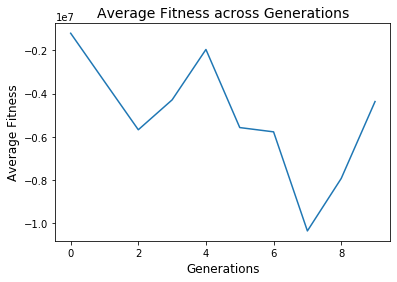

In [7]:
best_chromosome, final_fitness, train_err, valid_err = darwin.train()

In [8]:
final_fitness

-952456.8456173951

In [9]:
best_chromosome

array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.92906931e-11, -4.86466915e-12])

In [10]:
train_err

483324.9916561415

In [11]:
valid_err

469131.85396125366

In [12]:
input()
# to prevent submissions on running all cells

''

In [13]:
status = server.submit(TEAM_ID, list(best_chromosome))
status

'successfully submitted'

In [14]:
vec = [ 0.00000000e+00,  9.98864657e+00, -4.77957322e+00,  3.95299543e-02,
        2.73372189e-02,  5.92788688e-05, -4.30592004e-05, -8.98920518e-08,
        2.50868944e-08,  2.95056457e-11, -4.85882545e-12]
t,v = server.get_errors(TEAM_ID, list(vec))
print(t,v)

492657.9122416945 481330.2051588581


In [15]:
darwin.max_fitness_across_generations


-952456.8456173951

In [16]:
darwin.max_fitness_across_generations/6

-158742.80760289918

In [17]:
darwin.best_chromosome_across_generations

array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.92906931e-11, -4.86466915e-12])

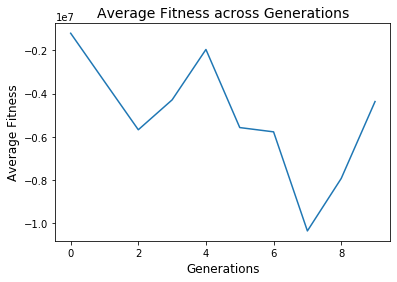

In [18]:
plt.plot(darwin.avg_fitness)
plt.xlabel('Generations', fontsize=12)
plt.ylabel('Average Fitness', fontsize=12)
plt.title('Average Fitness across Generations', fontsize=14)
plt.show()

In [19]:
print(darwin.store)

[(array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.94890102e-11, -4.86466915e-12]), -952955.4326271861, 407353.9920217353, 545601.4406054508), (array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.92906931e-11, -4.86466915e-12]), -952456.8456173951, 483324.9916561415, 469131.85396125366), (array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.76491722e-02,  5.91835093e-05, -4.30664361e-05, -8.94891762e-08,
        2.50846721e-08,  2.94890102e-11, -4.86466915e-12]), -1756164.0866003465, 1112362.0426990348, 643802.0439013118), (array([ 0.00000000e+00,  1.00000000e+01, -4.84297691e+00,  3.97687874e-02,
        2.74207049e-02,  5.96116618e-05, -4.30664361e-05, -8.98739352e-08,
        2.50846721e-08,  2.94890102